# RODA data

In [1]:
import pandas as pd

INPUT_DATETIME_FORMAT = "%m/%d/%y %H:%M"
OUTPUT_DATETIME_FORMAT = "%Y-%m-%d %H:%M"

original_df = pd.read_csv("./data_samples/datos_roda.csv")
original_df['Fecha Inicio'] = pd.to_datetime(original_df['Fecha Inicio'], format=INPUT_DATETIME_FORMAT)
original_df['Fecha Fin'] = pd.to_datetime(original_df['Fecha Fin'], format=INPUT_DATETIME_FORMAT)
original_df['date'] = original_df['Fecha Inicio'].dt.strftime("%Y-%m-%d")

## RODA Number of Delivery Routes per Day, per Device

In [2]:
original_df_counts = original_df[['Dispositivo', 'date']].value_counts()
original_df_counts

Dispositivo  date      
Xch1238      2023-02-20    80
             2023-02-25    72
Xch1572      2023-09-23    72
Xch1238      2023-02-19    71
Xch1546      2023-06-02    69
                           ..
             2023-07-21     1
             2023-07-20     1
             2023-07-19     1
             2023-07-18     1
Xch1592      2023-12-11     1
Length: 2892, dtype: int64

The original dataset shows some devices logging over 80 delivery routes per day, indicating potential noise from non-valid routes. We'll now identify and filter in these anomalies

In [3]:
original_df_counts[original_df_counts>30]

Dispositivo  date      
Xch1238      2023-02-20    80
             2023-02-25    72
Xch1572      2023-09-23    72
Xch1238      2023-02-19    71
Xch1546      2023-06-02    69
                           ..
Xch1572      2023-09-24    33
Xch1566      2023-09-24    32
Xch1431      2023-12-05    32
             2023-12-08    32
             2023-12-02    31
Length: 62, dtype: int64

Analysis reveals about 62 entries exhibiting this issue.

## Routes with null reference to clients

We identified that some of the divices are not assigned to any client so 'Referencia' column is null. Routes reported for a device that not reference to any rappi driver client should be ignore, since this routes could be related with devices tests. Lets check who are those devices.

In [6]:
not_references_devs_df = original_df[original_df['Referencia'].isnull()]
print(not_references_devs_df['Dispositivo'].value_counts())

Xch1556    296
Name: Dispositivo, dtype: int64


In our dataset, there is only one device, identified as 'XCH1556', that reported routes without an associated client reference. This device accounted for 296 routes, which represents only 1% of the total number of routes. Given that this constitutes a relatively small portion and is not significant in scale, we can consider excluding these routes from our analysis. Subsequently, we can investigate the reason behind the lack of a client assignment for this particular device.

In [10]:
Xch1556_df = original_df[original_df['Dispositivo'] == 'Xch1556']
Xch1556_df['Referencia'].value_counts()

Series([], Name: Referencia, dtype: int64)

Code and results above shows that device 'Xch1556' only contains routes with not reference to the client. Meaning that the device is still missing the client reference.

## Minimum and Maximum Distance Analysis

Initially, we'll exclude routes that are too short, to reduce noise in the data. Also removing routes with null `Referencia` because those are devices not assigned to any rappi driver yet.

In [14]:
original_df = original_df[original_df['Distancia']>10] # filter in routes with distance > than 10 meters
original_df = original_df[original_df['Referencia'].notnull()] # only count routes that are asigned to an user.

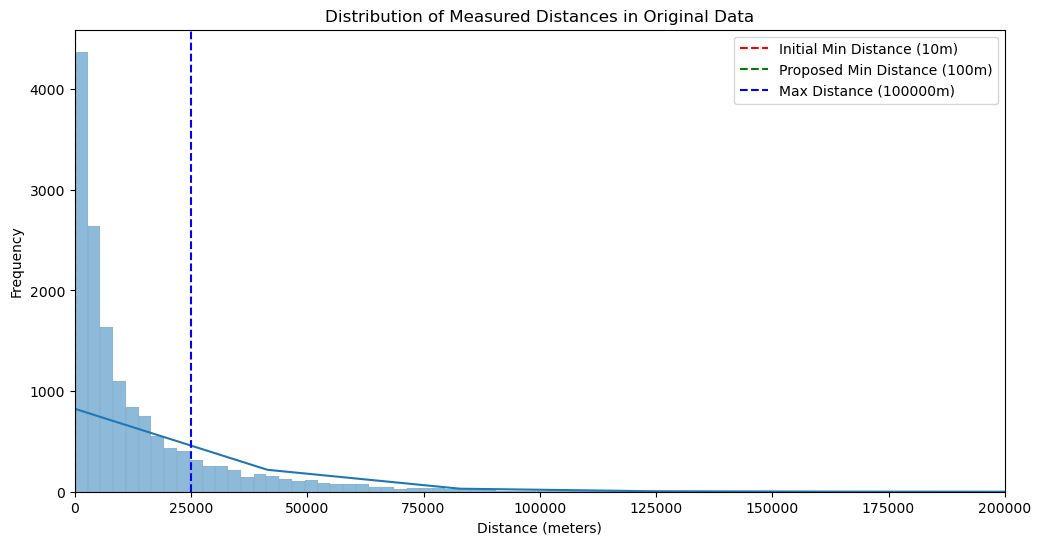

count    1.540300e+04
mean     1.590137e+04
std      1.002571e+05
min      1.057900e+01
25%      2.320680e+03
50%      6.586210e+03
75%      1.763635e+04
max      8.242150e+06
Name: Distancia, dtype: float64


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analyzing the distribution of measured distances
plt.figure(figsize=(12, 6))
sns.histplot(original_df['Distancia'], bins=3000, kde=True)
plt.title('Distribution of Measured Distances in Original Data')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')

# Setting x-axis limits to focus on the area with more routes
# For example, focusing on distances less than 500 meters
plt.xlim(0, 200000)

# initial and proposed thresholds
plt.axvline(10, color='r', linestyle='--', label='Initial Min Distance (10m)')
plt.axvline(100, color='g', linestyle='--', label='Proposed Min Distance (100m)')
plt.axvline(25000, color='b', linestyle='--', label='Max Distance (100000m)')
plt.legend()
plt.show()

# Display basic statistical details of the measured distances
distance_stats = original_df['Distancia'].describe()
print(distance_stats)

The original data includes some routes with excessive distances, reaching up to 8242km. This is unrealistic considering Bogota's size (33km north to south and 16km east to west). Therefore, I suggest setting 25km as the maximum logical distance for a delivery route. Let's examine the data after applying this filter.

In [16]:
original_df = original_df[original_df['Distancia']<25000] 

Next, we'll explore how the distribution appears post-filtering.

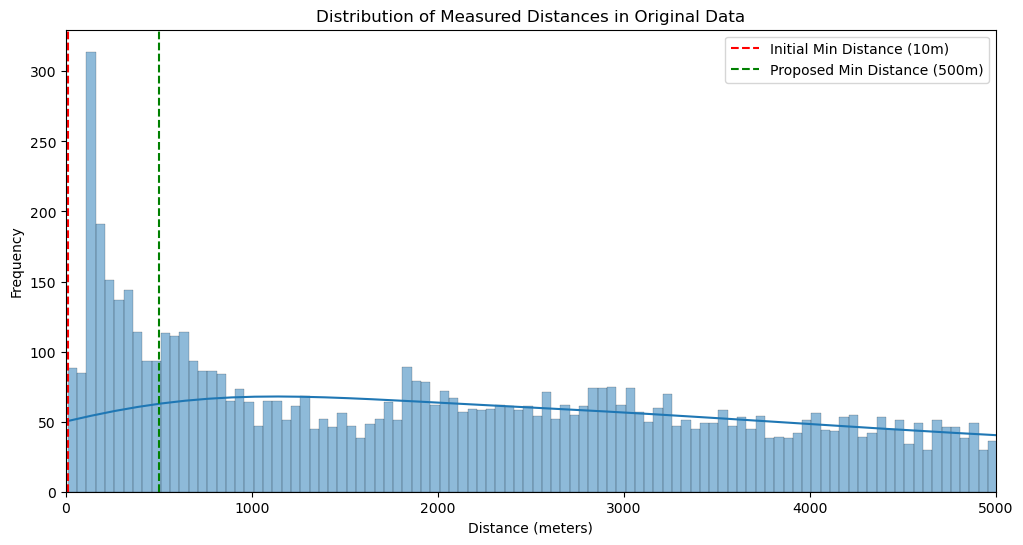

count    12748.000000
mean      6870.225032
std       6400.323893
min         10.579000
25%       1831.820000
50%       4701.945000
75%      10499.225000
max      24996.100000
Name: Distancia, dtype: float64


In [37]:
# Analyzing the distribution of measured distances
plt.figure(figsize=(12, 6))
sns.histplot(original_df['Distancia'], bins=500, kde=True)
plt.title('Distribution of Measured Distances in Original Data')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')

# Setting x-axis limits to focus on the area with more routes
# For example, focusing on distances less than 500 meters
plt.xlim(0, 5000)

# initial and proposed thresholds
plt.axvline(10, color='r', linestyle='--', label='Initial Min Distance (10m)')
plt.axvline(500, color='g', linestyle='--', label='Proposed Min Distance (500m)')
#plt.axvline(25000, color='b', linestyle='--', label='Max Distance (25000m)')
plt.legend()
plt.show()

# Display basic statistical details of the measured distances
distance_stats = original_df['Distancia'].describe()
print(distance_stats)

An initial analysis suggests 100 meters as a feasible minimum for delivery routes. However, for bicycle delivery services, this distance might be impractically short. Considering operational costs and logistical efforts, a minimum of 500 meters, particularly in dense urban areas, seems more reasonable for such services.

## Duration distribution analysis

Initially, we'll exclude routes that are too short, to reduce noise in the data.

In [38]:
original_df = original_df[original_df['Distancia']>=500] 

We will now remove routes exceeding a duration of one day.

In [43]:
original_df['durationMinutes'] = (original_df['Fecha Fin'] - original_df['Fecha Inicio']).dt.total_seconds() / 60
original_df = original_df[original_df['durationMinutes']<1440] 

Subsequently, we'll visualize the data through a histogram of durations.

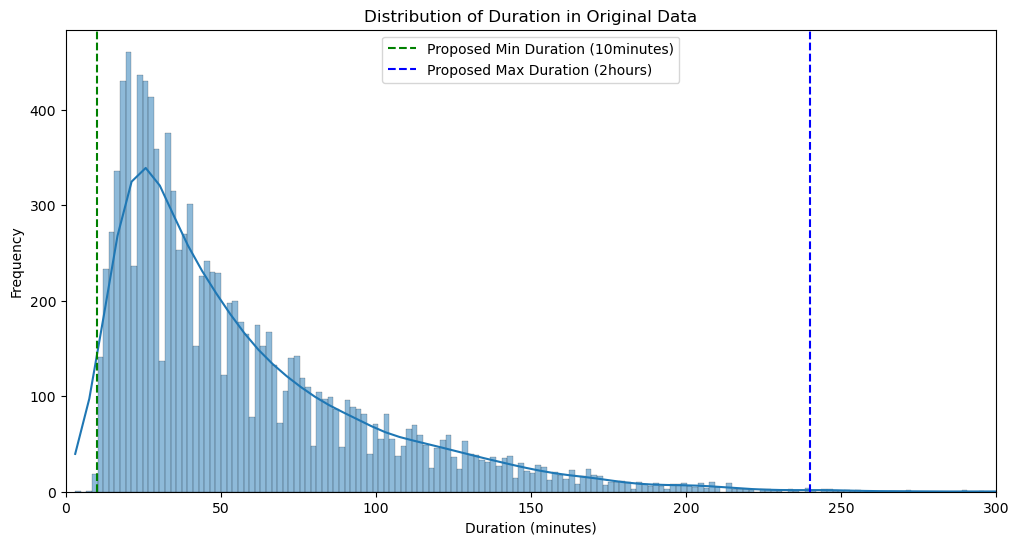

count    11340.000000
mean        57.314374
std         46.689169
min          3.000000
25%         26.000000
50%         43.000000
75%         75.000000
max        908.000000
Name: durationMinutes, dtype: float64


In [50]:
# Analyzing the distribution of measured distances
plt.figure(figsize=(12, 6))
sns.histplot(original_df['durationMinutes'], bins=500, kde=True)
plt.title('Distribution of Duration in Original Data')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')

# Setting x-axis limits to focus on the area with more routes
# For example, focusing on distances less than 500 meters
plt.xlim(0, 300)

# initial and proposed thresholds
plt.axvline(10, color='g', linestyle='--', label='Proposed Min Duration (10minutes)')
plt.axvline(240, color='b', linestyle='--', label='Proposed Max Duration (2hours)')
plt.legend()
plt.show()

# Display basic statistical details of the measured distances
distance_stats = original_df['durationMinutes'].describe()
print(distance_stats)

Based on the histogram, I propose setting the minimum route duration at 10 minutes, aligning with Rappi's service offering, and capping it at 2 hours. The plot indicates that only a few routes exceed this duration.

# Guajira Data

In [12]:
INPUT_DATETIME_FORMAT = "%m/%d/%y %H:%M"
OUTPUT_DATETIME_FORMAT = "%Y-%m-%d %H:%M"

original_df = pd.read_csv("./data_samples/datos_guajira.csv")
original_df['Fecha Inicio'] = pd.to_datetime(original_df['Fecha Inicio'], format=INPUT_DATETIME_FORMAT)
original_df['Fecha Fin'] = pd.to_datetime(original_df['Fecha Fin'], format=INPUT_DATETIME_FORMAT)
original_df['date'] = original_df['Fecha Inicio'].dt.strftime("%Y-%m-%d")

## Number of Delivery Routes per Day, per Device

In [13]:
original_df_counts = original_df[['Dispositivo', 'date']].value_counts()
original_df_counts

Dispositivo  date      
Xch1546      2023-06-02    69
             2023-06-01    39
             2023-09-17    38
             2023-09-13    35
             2023-09-14    34
                           ..
Xch1485      2023-11-29     1
             2023-11-22     1
             2023-11-18     1
             2023-11-09     1
Xch1201      2023-03-07     1
Length: 980, dtype: int64

In [14]:
original_df_counts[original_df_counts>30]

Dispositivo  date      
Xch1546      2023-06-02    69
             2023-06-01    39
             2023-09-17    38
             2023-09-13    35
             2023-09-14    34
Xch1559      2023-09-24    34
Xch1580      2023-09-24    33
Xch1546      2023-09-16    33
             2023-09-15    33
dtype: int64

## Routes with null reference to clients

In [19]:
not_references_devs_df = original_df[original_df['Referencia'].isnull()]
print(not_references_devs_df['Dispositivo'].value_counts())

Xch1487    363
Xch1485    305
Xch1488    270
Xch1477    193
Xch1480    181
Xch1478    180
Xch1483    100
Xch1484     17
Xch1479     16
Xch1481     15
Xch1461      7
Xch1476      6
Xch1482      3
Xch1475      3
Xch1489      2
Xch1471      1
Name: Dispositivo, dtype: int64


For bycicles, there is endeed more than 1 devices with not reference to any client. Lets check how many routes are reported under this devices.

In [21]:
not_ref_devs_counts = len(not_references_devs_df)
total_routes_counts = len(original_df)

print(f"there are {not_ref_devs_counts} with not client ref. About {not_ref_devs_counts*100/total_routes_counts:0.2f}% of the total amount of routes.")

there are 1662 with not client ref. About 38.28% of the total amount of routes.


Although it seems prudent to exclude bicycles with null client references from our analysis, it is important to investigate why these particular devices lack such references. This issue is not trivial, as it affects a significant portion of our data, approximately 38.28%. Understanding and addressing the root cause is crucial to ensure the integrity of our dataset.

In [18]:
not_references_devs_df = original_df[original_df['Dispositivo'].isin(not_references_devs_df['Dispositivo'])]

# Creating tuples from two columns
tuples = list(zip(not_references_devs_df['Dispositivo'], not_references_devs_df['Referencia']))

# Getting unique tuples
unique_tuples = pd.unique(tuples)

print(unique_tuples)

[('Xch1485', nan) ('Xch1487', nan) ('Xch1478', nan) ('Xch1488', nan)
 ('Xch1480', nan) ('Xch1483', nan) ('Xch1477', nan) ('Xch1481', nan)
 ('Xch1484', nan) ('Xch1479', nan) ('Xch1482', nan) ('Xch1475', nan)
 ('Xch1476', nan) ('Xch1461', nan) ('Xch1471', nan) ('Xch1489', nan)]


Codeblock above shows that none of the devices reporting null references have not ever report a route with a client reference.

## Minimum and Maximum Distance Analysis

In [ ]:
original_df = original_df[original_df['Distancia']>10] # filter in routes with distance > than 10 meters
original_df = original_df[original_df['Referencia'].notnull()] # only count routes that are asigned to an user.

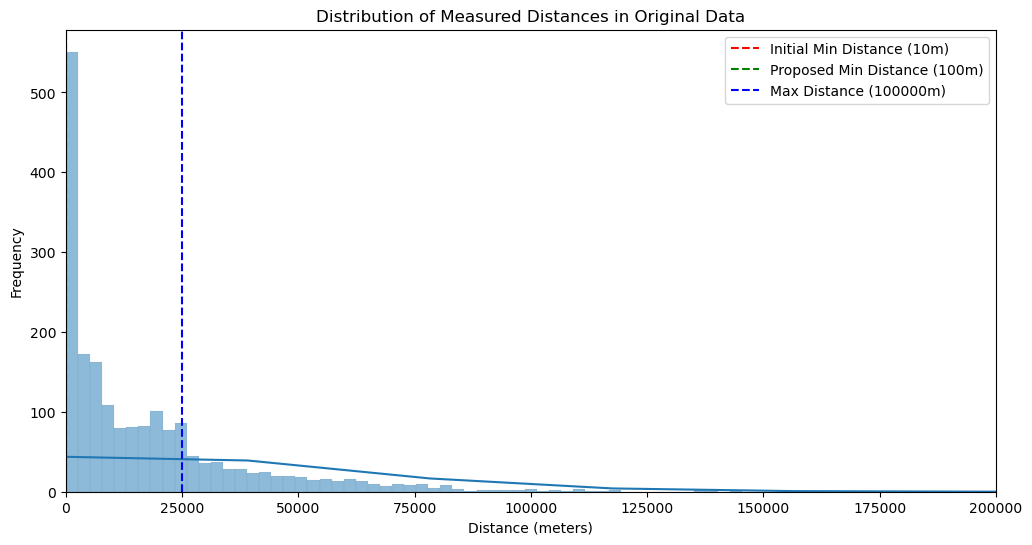

count    1.953000e+03
mean     2.279173e+04
std      1.789734e+05
min      1.311700e+01
25%      2.013680e+03
50%      9.829120e+03
75%      2.498180e+04
max      7.791040e+06
Name: Distancia, dtype: float64


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analyzing the distribution of measured distances
plt.figure(figsize=(12, 6))
sns.histplot(original_df['Distancia'], bins=3000, kde=True)
plt.title('Distribution of Measured Distances in Original Data')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')

# Setting x-axis limits to focus on the area with more routes
# For example, focusing on distances less than 500 meters
plt.xlim(0, 200000)

# initial and proposed thresholds
plt.axvline(10, color='r', linestyle='--', label='Initial Min Distance (10m)')
plt.axvline(100, color='g', linestyle='--', label='Proposed Min Distance (100m)')
plt.axvline(25000, color='b', linestyle='--', label='Max Distance (100000m)')
plt.legend()
plt.show()

# Display basic statistical details of the measured distances
distance_stats = original_df['Distancia'].describe()
print(distance_stats)

As with devices from RODA, Guajira Bicycles data includes some routes with excessive distances, reaching up to 7791km. This is unrealistic considering Bogota's size (33km north to south and 16km east to west). Therefore, I suggest setting 25km as the maximum logical distance for a delivery route. 

In [57]:
original_df = original_df[original_df['Distancia']<25000] 

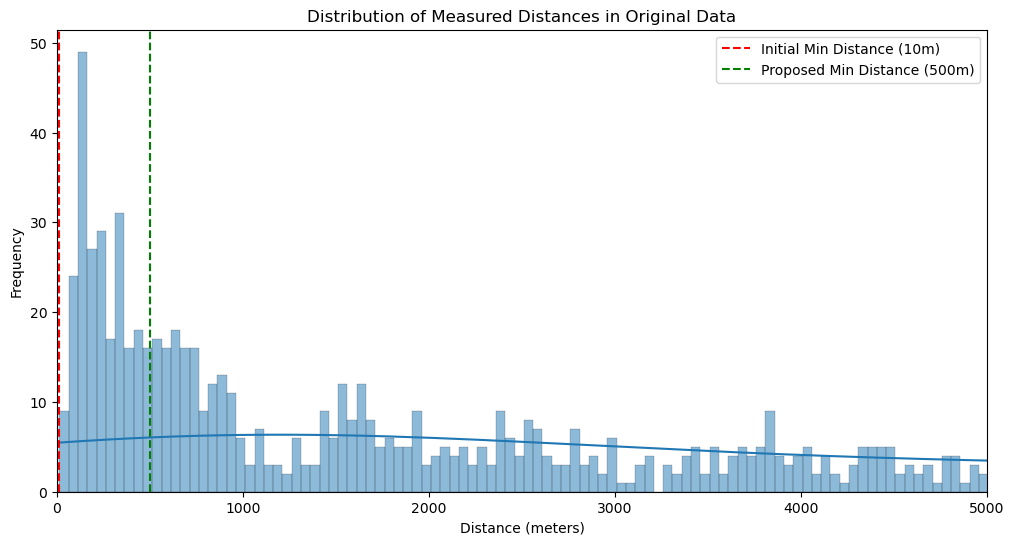

count     1465.000000
mean      7851.648473
std       7587.580290
min         13.117000
25%        987.778000
50%       5307.740000
75%      13515.600000
max      24981.800000
Name: Distancia, dtype: float64


In [58]:
# Analyzing the distribution of measured distances
plt.figure(figsize=(12, 6))
sns.histplot(original_df['Distancia'], bins=500, kde=True)
plt.title('Distribution of Measured Distances in Original Data')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')

# Setting x-axis limits to focus on the area with more routes
# For example, focusing on distances less than 500 meters
plt.xlim(0, 5000)

# initial and proposed thresholds
plt.axvline(10, color='r', linestyle='--', label='Initial Min Distance (10m)')
plt.axvline(500, color='g', linestyle='--', label='Proposed Min Distance (500m)')
#plt.axvline(25000, color='b', linestyle='--', label='Max Distance (25000m)')
plt.legend()
plt.show()

# Display basic statistical details of the measured distances
distance_stats = original_df['Distancia'].describe()
print(distance_stats)

An initial analysis suggests 100 meters as a feasible minimum for delivery routes. However, for bicycle delivery services, this distance might be impractically short. Considering operational costs and logistical efforts, a minimum of 500 meters, particularly in dense urban areas, seems more reasonable for such services.

## Duration distribution analysis

In [59]:
original_df = original_df[original_df['Distancia']>=500] 

We will now remove routes exceeding a duration of one day.

In [60]:
original_df['durationMinutes'] = (original_df['Fecha Fin'] - original_df['Fecha Inicio']).dt.total_seconds() / 60
original_df = original_df[original_df['durationMinutes']<1440] 

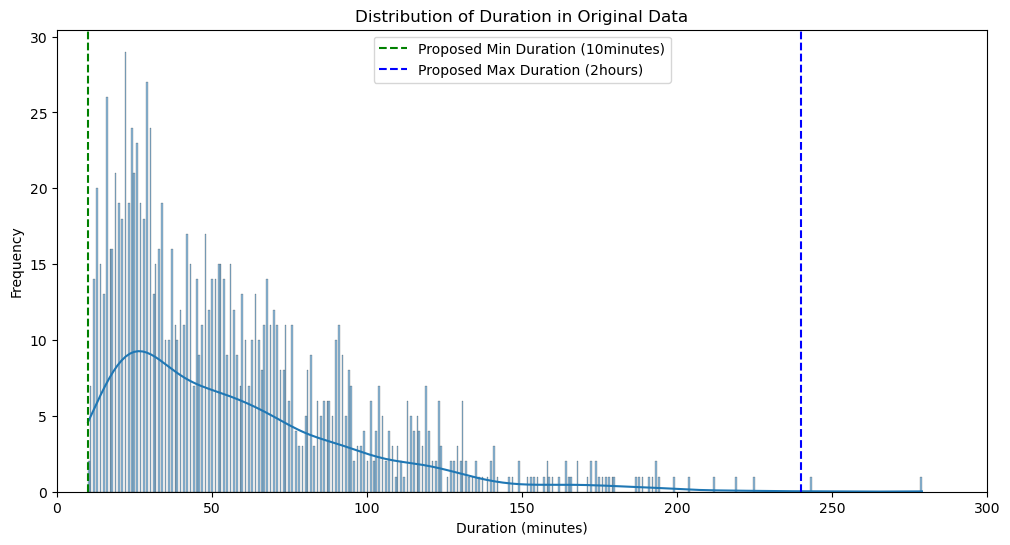

count    1235.000000
mean       57.380567
std        39.444370
min        10.000000
25%        27.000000
50%        48.000000
75%        76.000000
max       279.000000
Name: durationMinutes, dtype: float64


In [61]:
# Analyzing the distribution of measured distances
plt.figure(figsize=(12, 6))
sns.histplot(original_df['durationMinutes'], bins=500, kde=True)
plt.title('Distribution of Duration in Original Data')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')

# Setting x-axis limits to focus on the area with more routes
# For example, focusing on distances less than 500 meters
plt.xlim(0, 300)

# initial and proposed thresholds
plt.axvline(10, color='g', linestyle='--', label='Proposed Min Duration (10minutes)')
plt.axvline(240, color='b', linestyle='--', label='Proposed Max Duration (2hours)')
plt.legend()
plt.show()

# Display basic statistical details of the measured distances
distance_stats = original_df['durationMinutes'].describe()
print(distance_stats)

Based on the histogram, I propose setting the minimum route duration at 10 minutes, aligning with Rappi's service offering, and capping it at 2 hours. The plot indicates that only a few routes exceed this duration.